In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/33624
# 标题：市场宽度—极速—从20天307s,到200天43s

from jqdata import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

In [2]:
def getStockIndustry(p_stocks, p_industries_type, p_day):
    # type: (list, str, datetime.date) -> pd.Series
    """
    返回股票代码与所属行业汉字名称的对照表
    :param p_stocks: 股票代码列表
    :param p_industries_type: 行业分类标准，例如sw_l1
    :param p_day: 日期
    :return: pd.Series
    """
    dict_stk_2_ind = {}
    stocks_industry_dict = get_industry(p_stocks, date=p_day)
    for stock in stocks_industry_dict:
        if p_industries_type in stocks_industry_dict[stock]:
            dict_stk_2_ind[stock] = stocks_industry_dict[stock][p_industries_type]['industry_code']
    #
    return pd.Series(dict_stk_2_ind)

In [3]:
def get_industry_width(p_end_date, p_count, p_industries_type):
    # 行业代码，行业名称
    s_industry = get_industries(name=p_industries_type, date=p_end_date)['name']
    s_industry.loc['999998'] = '全市场'
    s_industry.loc['999999'] = '合计'
    #
    trade_days = get_trade_days(end_date=p_end_date, count=p_count + 20)
    stock_list = list(get_all_securities(date=trade_days[0]).index)  # 最早的day之前20天就已经上市的股票
    s_stk_2_ind = getStockIndustry(p_stocks=stock_list, p_industries_type=p_industries_type, p_day=p_end_date)

    # 取数
    h = get_price(stock_list, end_date=p_end_date, frequency='1d', fields=['close'], count=p_count + 20, panel=False)
    h['date'] = pd.DatetimeIndex(h.time).date
    df_close = h.pivot(index='code', columns='date', values='close').dropna(axis=0)
    df_ma20 = df_close.rolling(window=20, axis=1).mean().iloc[:, -p_count:]

    df_bias = (df_close.iloc[:, -p_count:] > df_ma20)  # type: pd.DataFrame
    # 每个交易日全市场的总体状况：Close在MA20之上的比例
    s_mkt_ratio = ((100.0 * df_bias.sum()) / df_bias.count()).round()
    df_bias['industry_code'] = s_stk_2_ind

    # df_ratio: index: 行业代码, columns: 日期
    df_ratio = ((df_bias.groupby('industry_code').sum() * 100.0) / df_bias.groupby(
        'industry_code').count()).round()  # type: pd.DataFrame
    #
    s_mkt_sum = df_ratio.sum()  # 每日合计
    #
    df_ratio.loc['999998'] = s_mkt_ratio
    df_ratio.loc['999999'] = s_mkt_sum
    # 行业汉字名称
    df_ratio['name'] = s_industry
    #
    df_result = df_ratio.set_index('name').T
    #
    for col in df_result.columns:
        df_result[col] = df_result[col].astype("int32")
    #
    df_result.sort_index(ascending=False, inplace=True)
    df_result.index.name = ''
    df_result.columns.name = ''
    #
    return df_result

In [4]:
def show_industry_width(p_count, df):
    fig = plt.figure(figsize=(16, p_count))
    grid = plt.GridSpec(1, 10)
    cmap = sns.diverging_palette(200, 10, as_cmap=True)
    heatmap1 = fig.add_subplot(grid[:, :-1])
    heatmap1.xaxis.set_ticks_position('top')
    sns.heatmap(df[df.columns[:-1]], vmin=0, vmax=100, annot=True, fmt="d",
                cmap=cmap,
                annot_kws={'size': 10}, cbar=False)
    heatmap2 = fig.add_subplot(grid[:, -1])
    heatmap2.xaxis.set_ticks_position('top')
    sns.heatmap(df[[df.columns[-1]]], vmin=0,
                vmax=(len(df.columns) - 2) * 100,
                annot=True, fmt="d", cmap=cmap, annot_kws={'size': 10})

    plt.yticks([])
    plt.show()
    plt.style.use({'figure.figsize': (16, 8)})
    df[df.columns[-1]].plot()

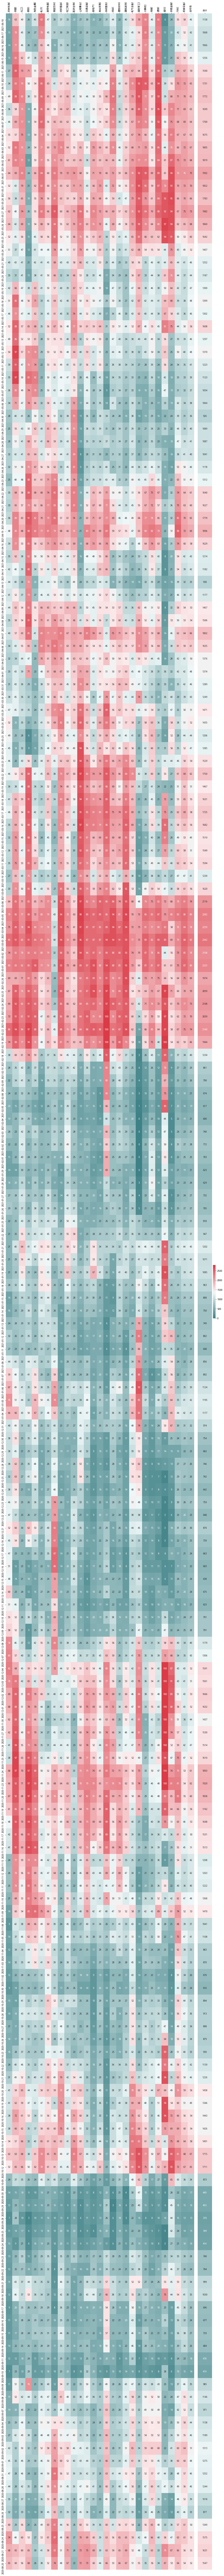

CPU times: user 38.6 s, sys: 1.69 s, total: 40.3 s
Wall time: 42 s


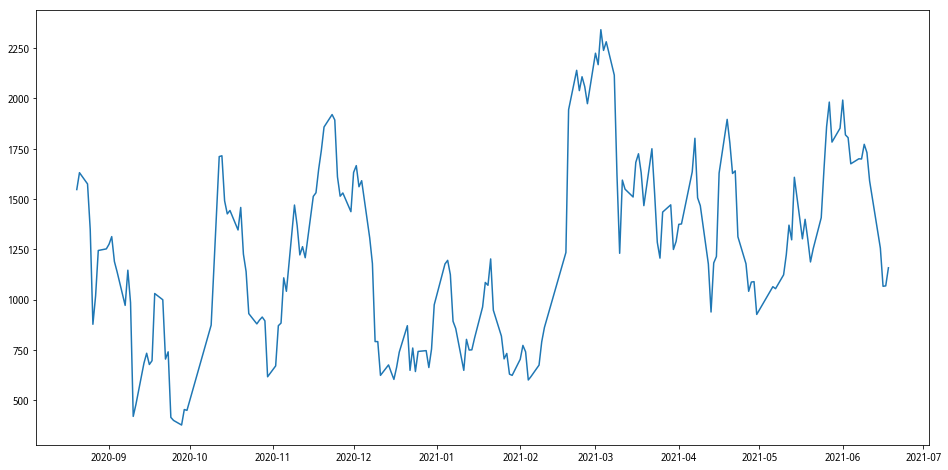

In [6]:
%%time
# 行业分类
industries_type = 'sw_l1'
# "sw_l1": 申万一级行业
# "jq_l1": 聚宽一级行业
end_date = datetime.date(2021, 6, 18)
# 计算天数
count_ = 200
#
market_capacity_daily = get_industry_width(end_date, count_, industries_type)
show_industry_width(count_, market_capacity_daily)